# the German tank problem

the Germans have a population of $n$ tanks labeled with serial numbers $1,2,...,n$ on the tanks. The number of tanks $n$ is unknown and of interest to the Allied forces. The Allied forces randomly capture $k$ tanks from the Germans with replacement and observe their serial numbers $\{x_1, x_2, ..., x_k\}$. The goal is to, from observing the serial numbers on this random sample of the tanks, estimate $n$.

the *estimator* of $n$ maps an outcome of the experiment to an estimate of $n$, $\hat{n}$.

In [1]:
using StatsBase
using PyPlot
using Statistics
using Printf

PyPlot.matplotlib.style.use("seaborn-pastel")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

## data structure for a tank

for elegance

In [2]:
struct Tank
    serial_no::Int
end
tank = Tank(3)

Tank(3)

## visualizing the captured tanks and their serial numbers

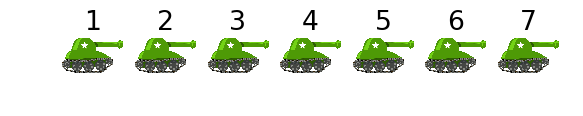

In [3]:
function viz_tanks(tanks::Array{Tank}, savename=nothing)
    nb_tanks = length(tanks)
    
    img = PyPlot.matplotlib.image.imread("tank.png")

    fig, ax = subplots(1, nb_tanks)
    for (t, tank) in enumerate(tanks)
        ax[t].imshow(img)
        ax[t].set_title(tank.serial_no)
        ax[t].axis("off")
    end
    tight_layout()
    
    if ! isnothing(savename)
        savefig(savename * ".png", format="png", dpi=300)
        # Linux command line tool to trim white space
        run(`convert $savename.png -trim $savename.png`)
    end
end

n = 7
tanks = [Tank(s) for s in 1:n]
viz_tanks(tanks)

## simulating tank capture

write a function `capture_tanks` to simulate the random sampling of `nb_tanks_captured` tanks from all `nb_tanks` tanks the Germans have (without replacement). return a random sample of tanks.

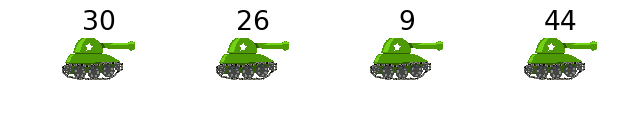

In [13]:
function capture_tanks(num_captured::Int, num_tanks::Int)
    return sample([Tank(i) for i in 1:num_tanks], num_captured, replace=false)
end

tanks = capture_tanks(4, 50)
viz_tanks(tanks)

## defining different estimators

an estimator maps an outcome $\{x_1, x_2, ..., x_k\}$ to an estimate for $n$, $\hat{n}$.

### estimator (1): maximum serial number

this is the maximum likelihood estimator.

\begin{equation}
\hat{n} = \max_i x_i
\end{equation}

In [14]:
function max_serial_no(captured_tanks::Array{Tank})
    return maximum([t.serial_no for t in captured_tanks])
end

max_serial_no(tanks)

44

### estimator (2): maximum serial number plus initial gap

\begin{equation}
\hat{n} = \max_i x_i + \bigl(\min_i x_i -1\bigr)
\end{equation}

In [18]:
function max_plus_first_gap(captured_tanks::Array{Tank})
    # only need to store this array once
    serials = [t.serial_no for t in captured_tanks]
    return maximum(serials) + minimum(serials) - 1
end

max_plus_first_gap(tanks)

52

### estimator (3): maximum serial number plus gap if samples are evenly spaced

\begin{equation}
\hat{n} = \max_i x_i + \bigl( \max_i x_i / k -1 \bigr)
\end{equation}

In [22]:
function max_plus_even_gap(captured_tanks::Array{Tank})
    serials = [t.serial_no for t in captured_tanks]
    max_serial = maximum(serials)
    # operations are costly; don't do it this way
    # return maximum(serials) * (1 + 1 / length(serials)) - 1
    return max_serial + max_serial / length(serials) - 1
end

max_plus_even_gap(tanks)

54.0

## assessing the bias and variance of different estimators

say the Germans have `nb_tanks` tanks, and we randomly capture `nb_tanks_captured`. what is the distribution of the estimators (over different outcomes of this random experiment), and how does the distribution compare to the true `nb_tanks`?

In [31]:
function sim_̂n(num_sims::Int, num_tanks::Int, num_tanks_captured::Int, estimator::Function)
    return [estimator(capture_tanks(num_tanks_captured, num_tanks)) for i in 1:num_sims]
end

num_tanks = 100
num_captured = 5
num_sims = 1000
mean(sim_̂n(num_sims, num_tanks, num_captured, max_serial_no))

84.74

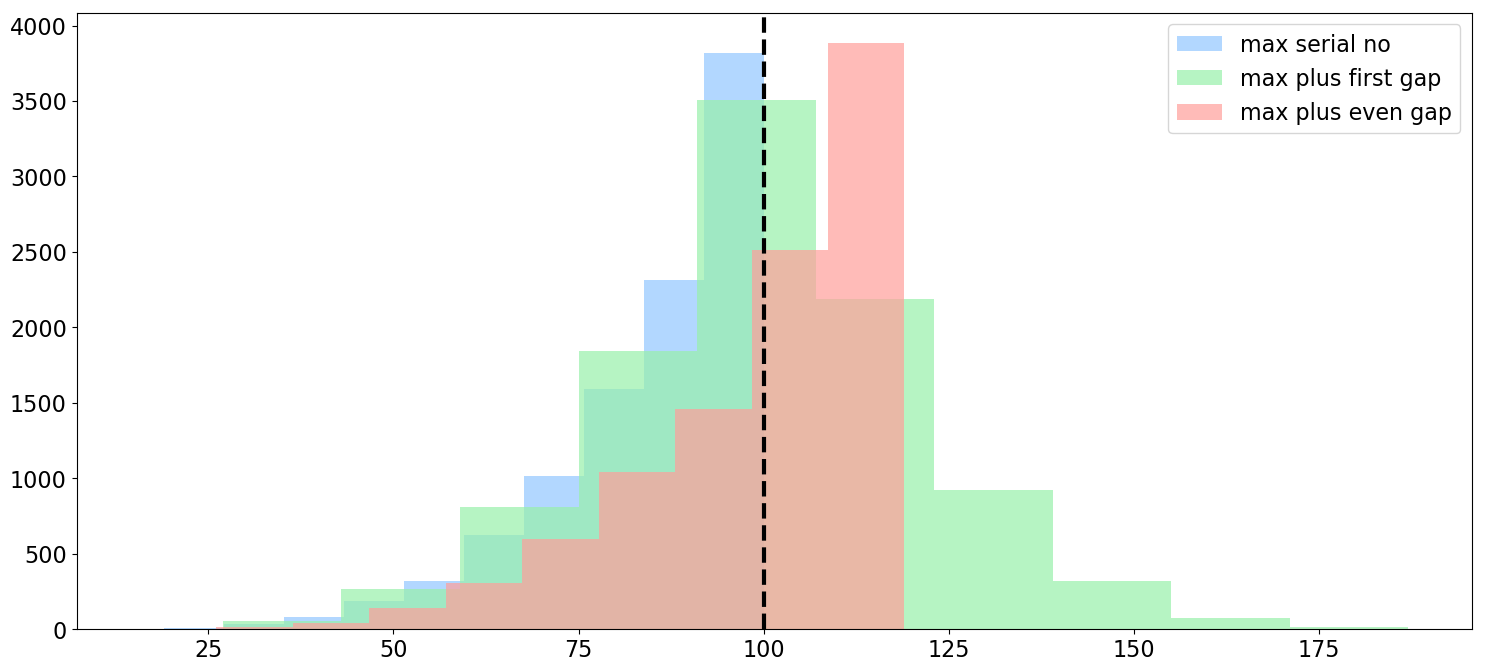

max serial no
     (̂n):84.2225
  std(̂n):13.687203063546997

max plus first gap
     (̂n):99.8724
  std(̂n):21.361482849628054

max plus even gap
     (̂n):100.1474
  std(̂n):16.423288759605004



PyObject <matplotlib.legend.Legend object at 0x7f73fedc2588>

In [52]:
num_sims = 10000

fig, ax = subplots(1, 1, figsize=(18, 8))
estimators = [max_serial_no, max_plus_first_gap, max_plus_even_gap]
for e in estimators
    results = sim_̂n(num_sims, num_tanks, num_captured, e)
    est_name = replace(string(e), "_" => " ")
    ax.hist(results, label=est_name, alpha=0.7)
    println(est_name)
    println("     (̂n):", mean(results))
    println("  std(̂n):", std(results), "\n")
end
ax.axvline(num_tanks, color="k", ls="--", linewidth=3)
ax.legend()

In [30]:
print(max_plus_even_gap)

max_plus_even_gap

notes:
* **efficiency**: small variance
* **consistency**: as number of samples in the estimate increases, the estimator converges
* **unbiasedness**: average estimator is correct

## what happens as we capture more and more tanks, i.e. increase $k$?

assess estimator (3).

## one-sided confidence interval

how confident are we that the Germans don't have *more* tanks?

significance level: $\alpha$

test statistic = estimator (3) = $\hat{n} = \max_i x_i + \bigl( \max_i x_i / k -1 \bigr)$

**null hypothesis**: the number of tanks is $n=n_0$<br>
**alternative hypothesis**: the number of tanks is less than $n_0$

we reject the null hypothesis (say, "the data does not support the null hypothesis") that the number of tanks is $n=n_0$ if the p-value is less than $\alpha$. the p-value is the probability that, if the null hypothesis is true, we get a test statistic equal to or smaller than we observed.

we want to find the highest $n_0$ such that we have statistical power to reject the null hypothesis in favor of the alternative hypothesis. this is the upper bound on the confidence interval!

then the idea is that, if the null hypothesis is that the number of tanks is absurdly large compared to the largest serial number we saw in our sample, it would be very unlikely that we would see such small serial numbers compared to the number of tanks, so we'd reject the null hypothesis. 

say $\alpha=0.05$ and we seek a 95% one-sided confidence interval